In [3]:
import mrc as Mrc
from scipy.fftpack import fftn, fftshift
import numpy as np
from tnia.plotting.projections import show_xyz_slice
import numpy as np
from tnia.plotting.projections import show_xyz_slice_center
import os
import sys

print(os.getcwd())

sys.path.insert(1, r'../../python')

from simreconpython.separate import makematrix, get_volume, separate, apodize_3d, normalize


c:\Users\bnort\work\Janelia\code\simrecon\notebooks\sandbox


In [4]:
raw_name = r'D:\Janelia\Data 2024-06-30\488cm cell 5 good signal_20240627_131236  Fail\488 nm 5 phases 0.81 NA React_All Linear SIM_cam1_1.mrc'
raw_mrc = Mrc.Mrc(raw_name)
raw = raw_mrc.data#[:,470:470+64,750:750+64]
print(raw.shape)
num_phases =      5
num_directions = 3

sxy, sxy, sz = raw_mrc.header.d[0], raw_mrc.header.d[1], raw_mrc.header.d[2]
print(sxy, sxy, sz)

(240, 1024, 1024)
0.13 0.13 0.25


0
1
2
3
4


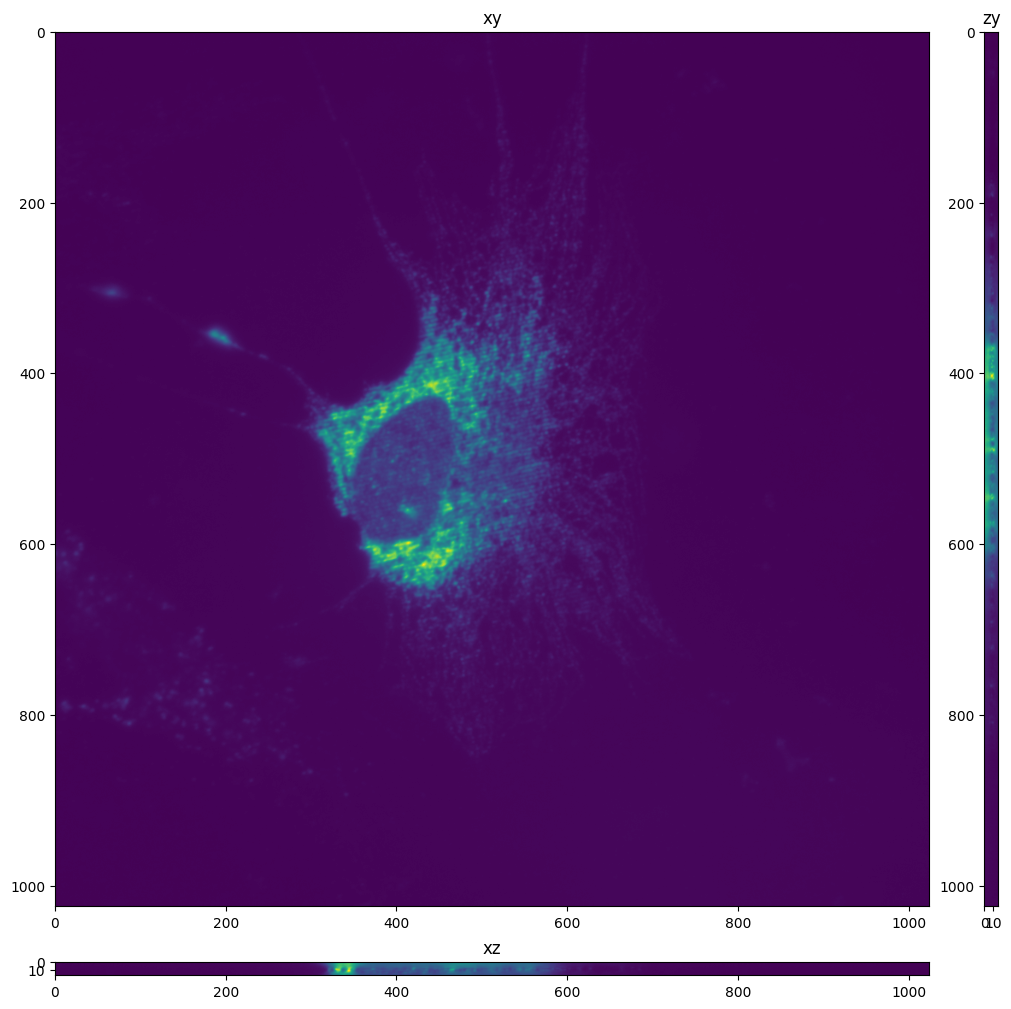

In [5]:
dir = 0
data_list = []
for n in range(num_phases):
    temp = get_volume(raw, n, dir, num_phases, num_directions)
    data_list.append(temp)

fig = show_xyz_slice_center(data_list[0])

In [6]:
data = np.array(data_list)   
print(data.shape)

sepmatrix = makematrix(5,3)
print(sepmatrix)
#separated = separate(sepmatrix, data)
separated = np.einsum('ij,jklm->iklm', sepmatrix, data)

(5, 16, 1024, 1024)
make matrix
[[ 1.          1.          1.          1.          1.        ]
 [ 1.          0.30901699 -0.80901699 -0.80901699  0.30901699]
 [ 0.          0.95105652  0.58778525 -0.58778525 -0.95105652]
 [ 1.         -0.80901699  0.30901699  0.30901699 -0.80901699]
 [ 0.          0.58778525 -0.95105652  0.95105652 -0.58778525]]


1894.0 244443.0


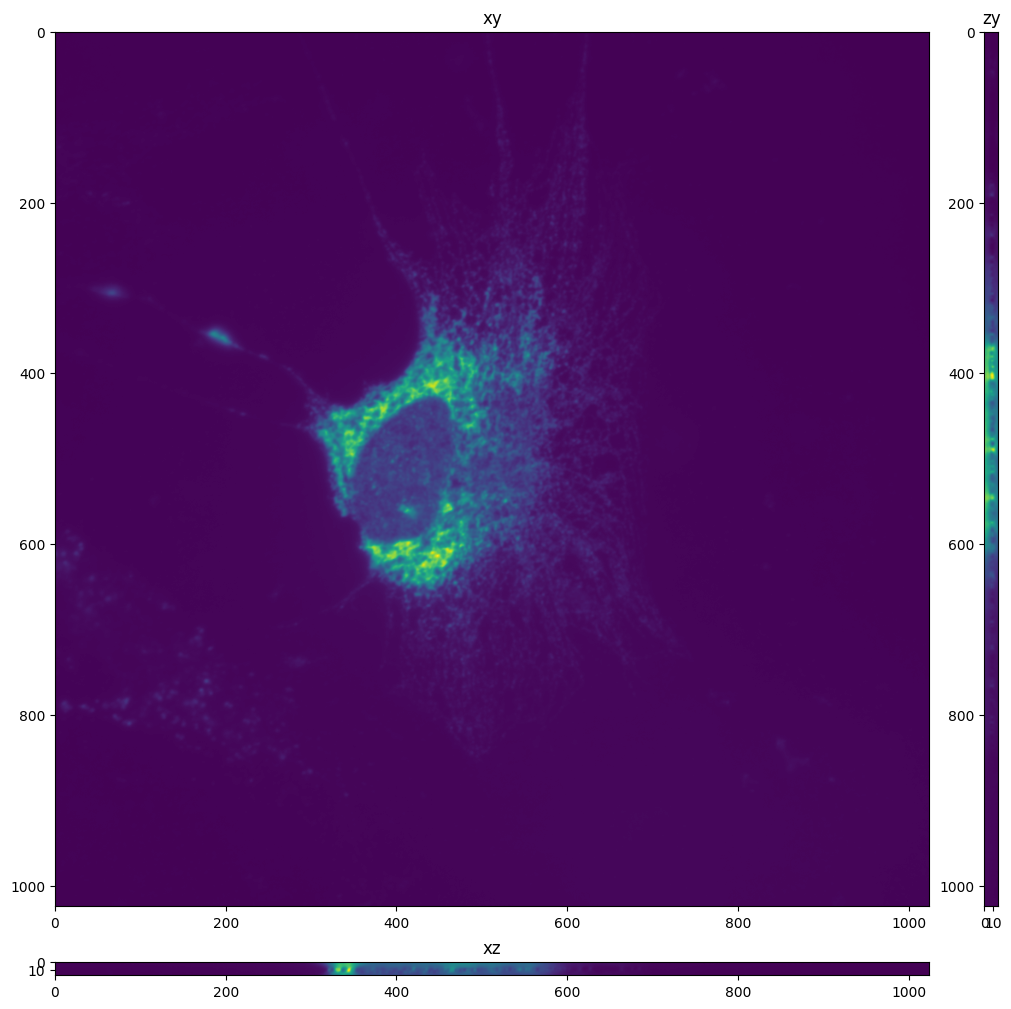

In [54]:
order0 = separated[0,:,:,:]
fig = show_xyz_slice_center(order0, sxy=1, sz=1)
print(order0.min(), order0.max())

In [33]:
import napari
viewer = napari.Viewer()
viewer.add_image(psf)

<Image layer 'psf' at 0x1516ec9a670>

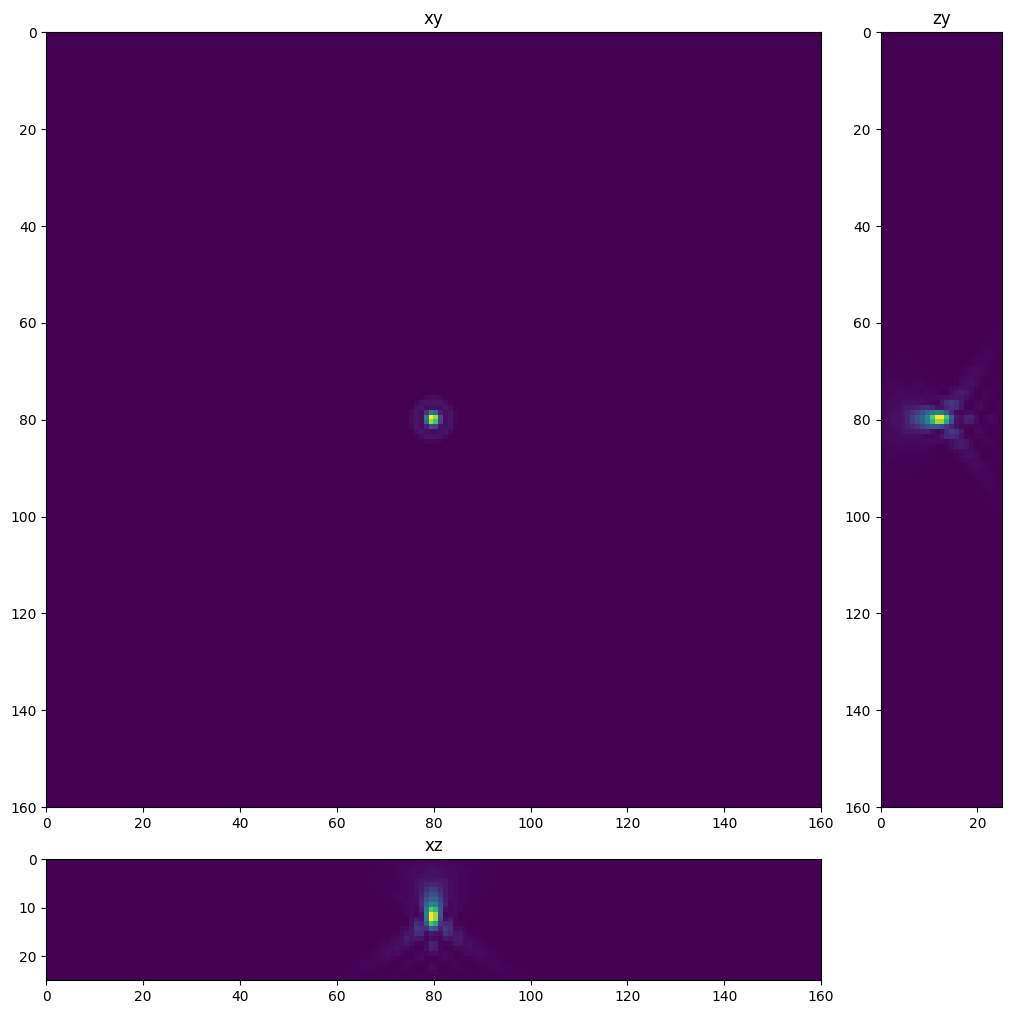

In [57]:
from tnia.deconvolution.psfs import gibson_lanni_3D, recenter_psf_axial

xy_s = 0.13
z_s = 0.25
w = 0.488
NA = 0.85
ni = 1.0
ns = 1.3

z_d1 = 65
z_d2=25
psf  = gibson_lanni_3D(NA, ni, ns, xy_s, z_s, 160, z_d1, 10, w, use_psfm=True)
psf = recenter_psf_axial(psf, z_d2)
psf = psf/psf.sum()
psf = psf[::-1, :, :]
fig = show_xyz_slice_center(psf)

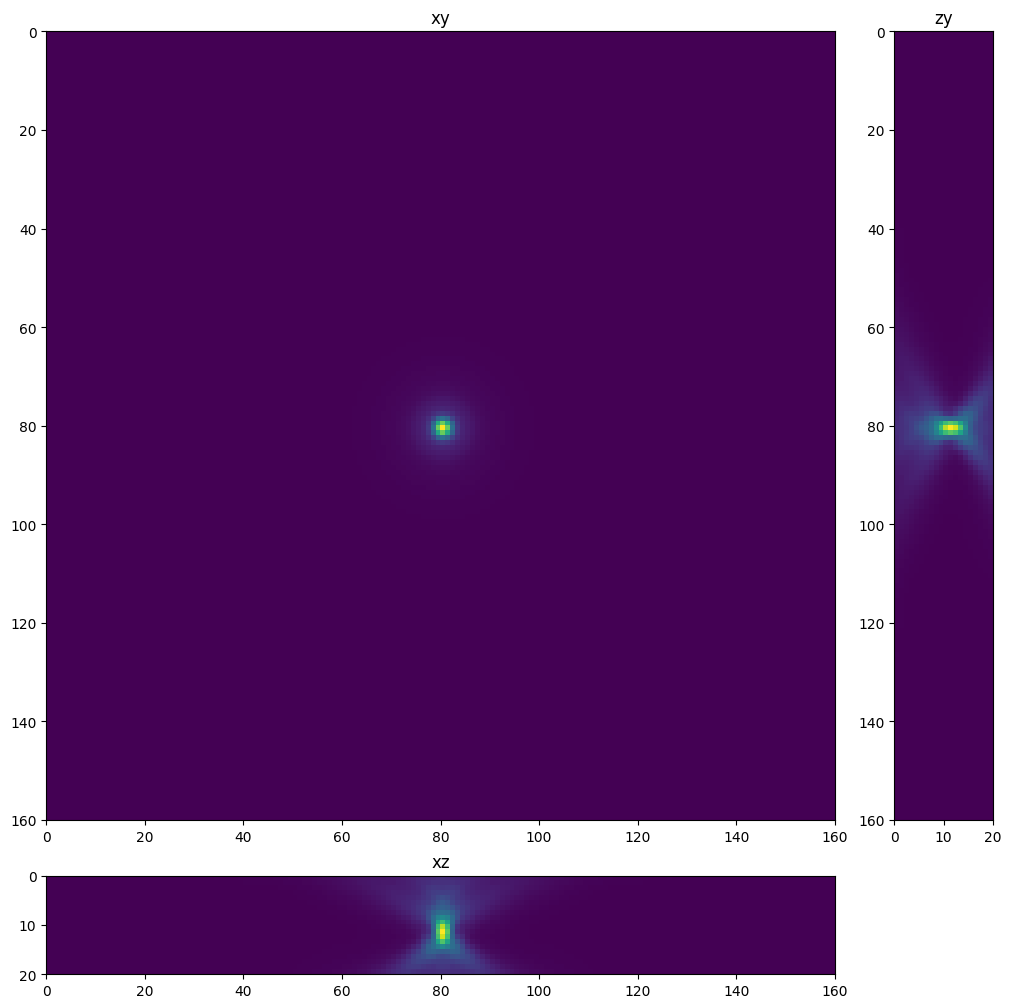

In [36]:
from skimage.io import imread
psf_file = r'C:\Users\bnort\work\Janelia\psfs\488nmLinOTF0\psf_3d_0.tif'
psf = imread(psf_file)
psf = psf[psf.shape[0]//2-10:psf.shape[0]//2+10, :, :]
#delta = 0.000001
psf[psf<0.00001]=0
#psf = psf - psf.min()
psf = psf / psf.sum()
fig = show_xyz_slice_center(psf)

In [26]:
from clij2fft.richardson_lucy import richardson_lucy_nc

In [27]:
print(order0.min(), order0.max())

1894.0 244443.0


In [58]:
decon = richardson_lucy_nc(order0, psf, numiterations=500)

get lib
calling convcorr 0 0


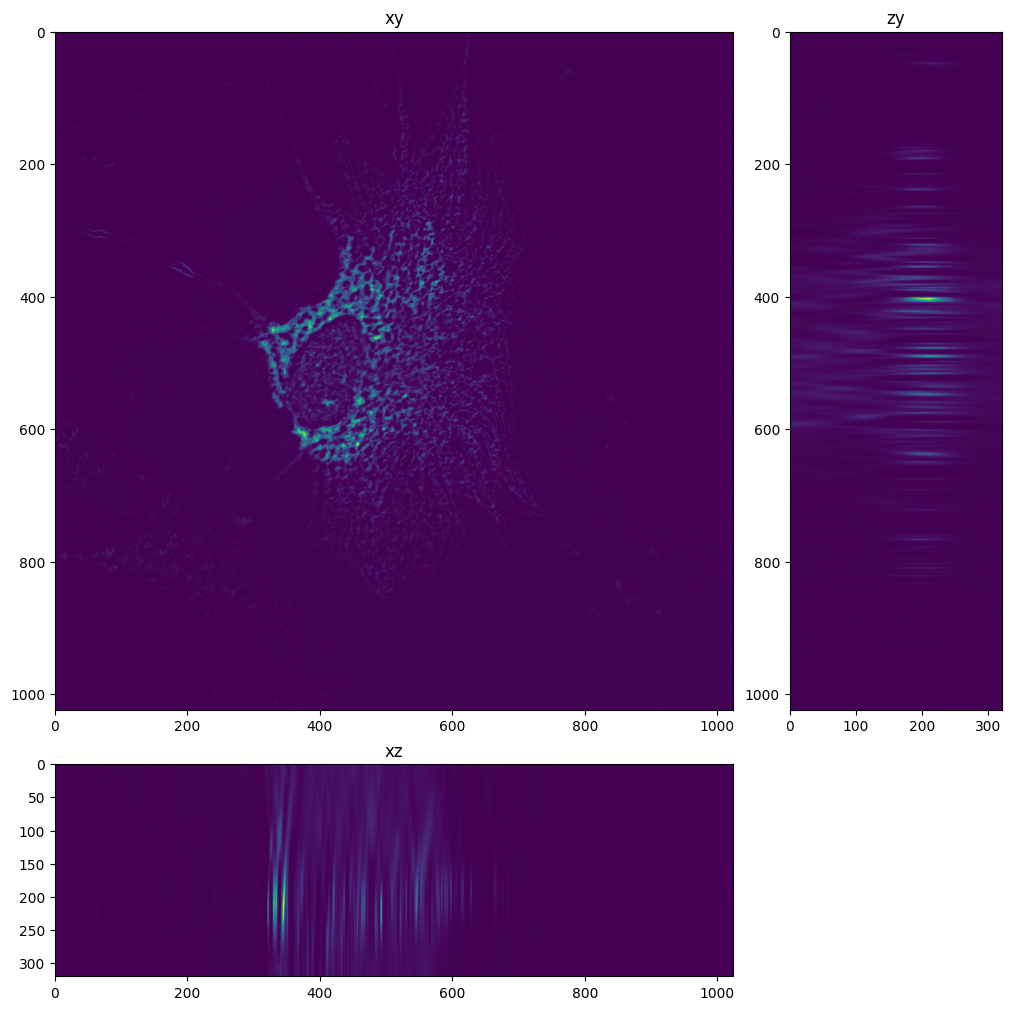

In [59]:
fig = show_xyz_slice_center(decon, sxy=1, sz=20)

In [47]:
decon.min(), decon.max()

(0.09344593, 1705042.8)

In [14]:
print(psf.max(), psf.min())

9.902673e-05 -2.312831e-08
